In [14]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any

In [15]:
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class SupplyPlanningModel:
    def __init__(self):
        """Initialize the supply planning optimization model."""
        self.model = pulp.LpProblem("Supply_Planning_Optimization", pulp.LpMinimize)
        self.periods = []
        self.products = []
        self.variables = {}
        
    def add_products(self, products):
        """Add products to the model."""
        self.products = products
        
    def add_periods(self, periods):
        """Add planning periods to the model."""
        self.periods = periods
        
    def setup_variables(self, initial_inventory=None):
        """Set up decision variables for production, inventory, and backlog."""
        if initial_inventory is None:
            initial_inventory = {p: 0 for p in self.products}
            
        # Production variables
        self.variables['production'] = pulp.LpVariable.dicts(
            "production",
            ((p, t) for p in self.products for t in self.periods),
            lowBound=0
        )
        
        # Setup decision variables (binary)
        self.variables['setup'] = pulp.LpVariable.dicts(
            "setup",
            ((p, t) for p in self.products for t in self.periods),
            cat='Binary'
        )
        
        # Inventory variables
        self.variables['inventory'] = pulp.LpVariable.dicts(
            "inventory",
            ((p, t) for p in self.products for t in self.periods),
            lowBound=0
        )
        
        # Backlog variables
        self.variables['backlog'] = pulp.LpVariable.dicts(
            "backlog",
            ((p, t) for p in self.products for t in self.periods),
            lowBound=0
        )
        
        # Overtime variables
        self.variables['overtime'] = pulp.LpVariable.dicts(
            "overtime",
            (t for t in self.periods),
            lowBound=0
        )
        
        self.initial_inventory = initial_inventory
        
    def add_demand_constraints(self, demand):
        """Add demand satisfaction constraints."""
        for p in self.products:
            for t in self.periods:
                if t == self.periods[0]:
                    self.model += (
                        self.initial_inventory[p] +
                        self.variables['production'][p,t] -
                        self.variables['inventory'][p,t] +
                        self.variables['backlog'][p,t] == demand[p][t]
                    )
                else:
                    self.model += (
                        self.variables['inventory'][p,t-1] +
                        self.variables['production'][p,t] -
                        self.variables['inventory'][p,t] +
                        self.variables['backlog'][p,t] -
                        self.variables['backlog'][p,t-1] == demand[p][t]
                    )

    def add_capacity_constraints(self, regular_capacity, max_overtime, production_time):
        """Add production capacity constraints with overtime and setup times."""
        for t in self.periods:
            # Regular capacity + overtime must meet production and setup requirements
            self.model += (
                pulp.lpSum(production_time[p] * self.variables['production'][p,t] +
                          self.variables['setup'][p,t] * production_time['setup']
                          for p in self.products) <= 
                regular_capacity + self.variables['overtime'][t]
            )
            # Limit overtime
            self.model += self.variables['overtime'][t] <= max_overtime

    def add_minimum_production_constraints(self, min_production):
        """Add minimum production quantity constraints when production occurs."""
        big_M = sum(min_production.values()) * len(self.periods) * 2
        for p in self.products:
            for t in self.periods:
                self.model += self.variables['production'][p,t] >= \
                    min_production[p] * self.variables['setup'][p,t]
                self.model += self.variables['production'][p,t] <= \
                    big_M * self.variables['setup'][p,t]

    def add_inventory_constraints(self, max_inventory):
        """Add maximum inventory level constraints."""
        for p in self.products:
            for t in self.periods:
                self.model += self.variables['inventory'][p,t] <= max_inventory[p]

    def set_objective(self, production_cost, inventory_cost, backlog_cost, 
                     setup_cost, overtime_cost):
        """Set the objective function to minimize total costs."""
        self.model += (
            # Production costs
            pulp.lpSum(production_cost[p] * self.variables['production'][p,t]
                      for p in self.products for t in self.periods) +
            # Setup costs
            pulp.lpSum(setup_cost[p] * self.variables['setup'][p,t]
                      for p in self.products for t in self.periods) +
            # Inventory holding costs
            pulp.lpSum(inventory_cost[p] * self.variables['inventory'][p,t]
                      for p in self.products for t in self.periods) +
            # Backlog costs
            pulp.lpSum(backlog_cost[p] * self.variables['backlog'][p,t]
                      for p in self.products for t in self.periods) +
            # Overtime costs
            pulp.lpSum(overtime_cost * self.variables['overtime'][t]
                      for t in self.periods)
        )
        
    def solve(self):
        """Solve the optimization model."""
        status = self.model.solve()
        return pulp.LpStatus[status]
        
    def get_results(self):
        """Get the optimization results as a pandas DataFrame."""
        results = {
            'production': {(p,t): self.variables['production'][p,t].value()
                         for p in self.products for t in self.periods},
            'setup': {(p,t): self.variables['setup'][p,t].value()
                     for p in self.products for t in self.periods},
            'inventory': {(p,t): self.variables['inventory'][p,t].value()
                        for p in self.products for t in self.periods},
            'backlog': {(p,t): self.variables['backlog'][p,t].value()
                       for p in self.products for t in self.periods},
            'overtime': {t: self.variables['overtime'][t].value()
                        for t in self.periods}
        }
        
        return pd.DataFrame([
            {'product': p,
             'period': t,
             'production': results['production'][p,t],
             'setup': results['setup'][p,t],
             'inventory': results['inventory'][p,t],
             'backlog': results['backlog'][p,t],
             'overtime': results['overtime'][t]}
            for p in self.products
            for t in self.periods
        ])

    def visualize_results(self, results):
        """Create visualizations of the planning results."""
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Production and Demand Plot
        for p in self.products:
            prod_data = results[results['product'] == p]
            axes[0,0].plot(prod_data['period'], prod_data['production'], 
                          marker='o', label=f'{p} Production')
        axes[0,0].set_title('Production Schedule')
        axes[0,0].set_xlabel('Period')
        axes[0,0].set_ylabel('Units')
        axes[0,0].legend()
        axes[0,0].grid(True)
        
        # Inventory Levels
        for p in self.products:
            inv_data = results[results['product'] == p]
            axes[0,1].plot(inv_data['period'], inv_data['inventory'], 
                          marker='s', label=f'{p} Inventory')
        axes[0,1].set_title('Inventory Levels')
        axes[0,1].set_xlabel('Period')
        axes[0,1].set_ylabel('Units')
        axes[0,1].legend()
        axes[0,1].grid(True)
        
        # Backlog Levels
        for p in self.products:
            back_data = results[results['product'] == p]
            axes[1,0].plot(back_data['period'], back_data['backlog'], 
                          marker='d', label=f'{p} Backlog')
        axes[1,0].set_title('Backlog Levels')
        axes[1,0].set_xlabel('Period')
        axes[1,0].set_ylabel('Units')
        axes[1,0].legend()
        axes[1,0].grid(True)
        
        # Overtime Hours
        overtime_data = results.groupby('period')['overtime'].first()
        axes[1,1].bar(overtime_data.index, overtime_data.values)
        axes[1,1].set_title('Overtime Hours')
        axes[1,1].set_xlabel('Period')
        axes[1,1].set_ylabel('Hours')
        axes[1,1].grid(True)
        
        plt.tight_layout()
        return fig

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/sgromme/source/sp_constraints/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/d643110249e4480a9ecdae7156ae8f9f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/d643110249e4480a9ecdae7156ae8f9f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 45 COLUMNS
At line 198 RHS
At line 239 BOUNDS
At line 248 ENDATA
Problem MODEL has 40 rows, 36 columns and 100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 22131.9 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0004I processed model has 28 rows, 36 columns (8 integer (8 of which binary)) and 88 elements
Cbc0038I Initial state - 4 integers unsatisfied sum - 0.8
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 23996 iterations 6
Cbc0038I Solution fou

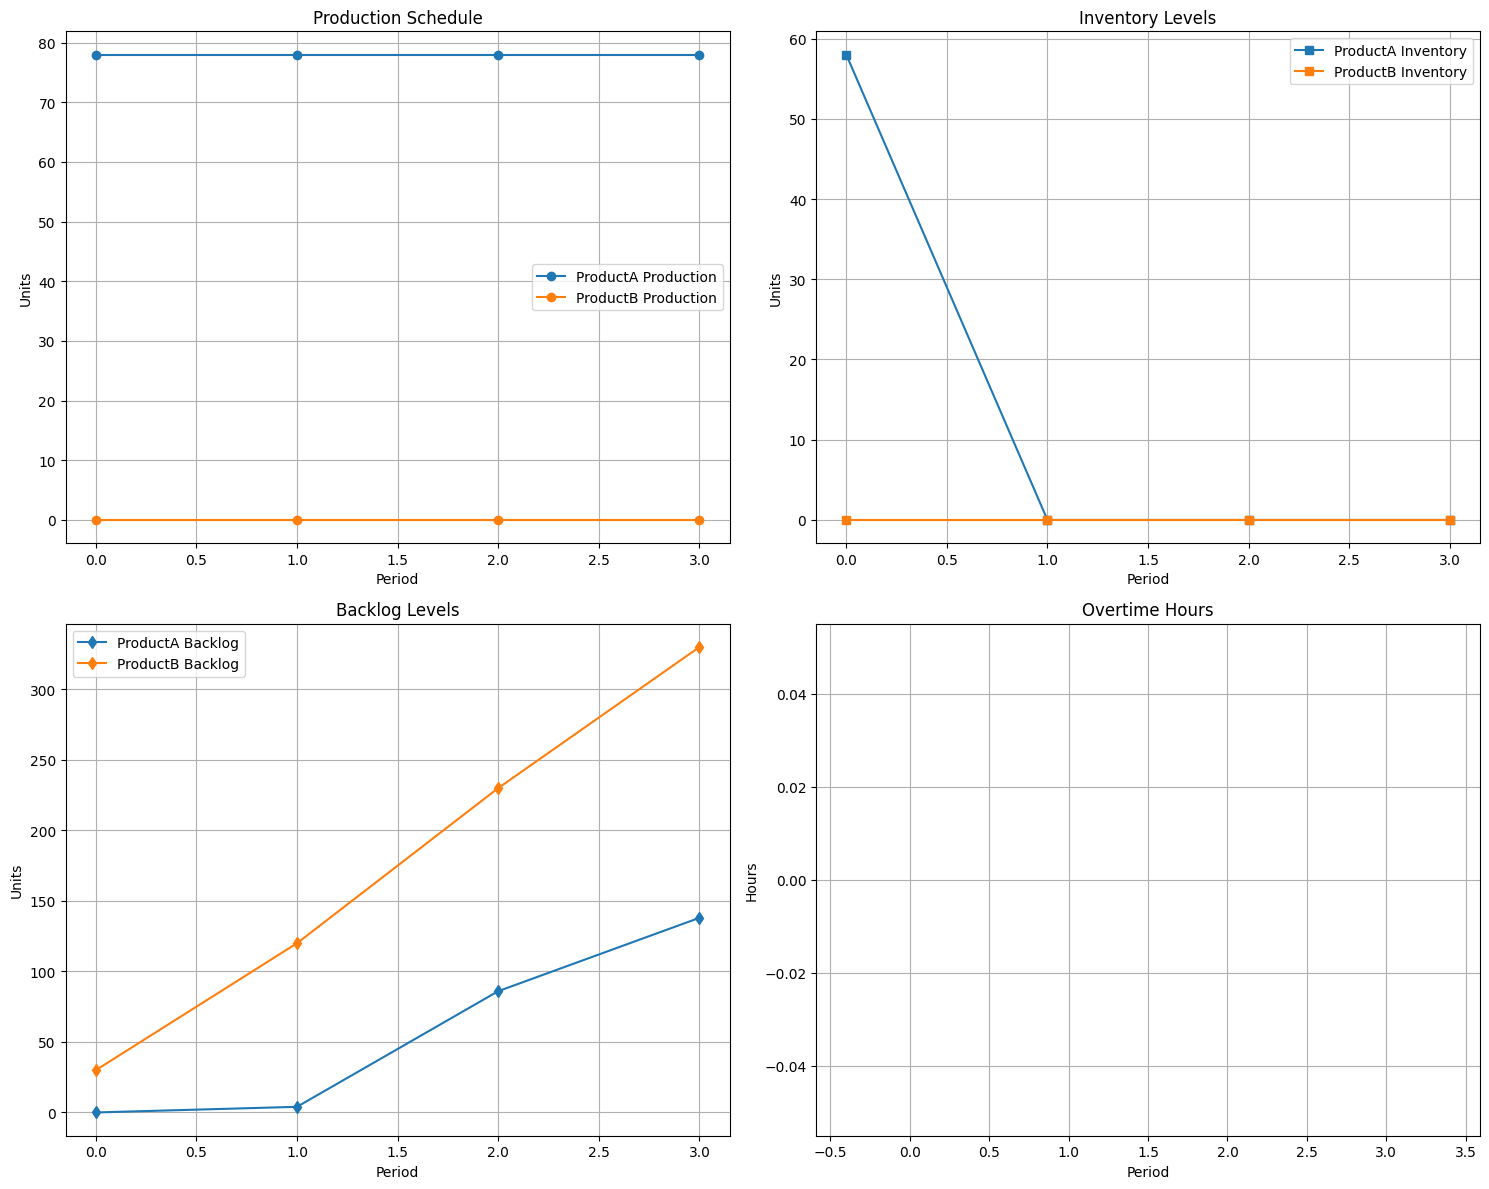

In [16]:
# Example usage
model = SupplyPlanningModel()

# Define products and periods
products = ['ProductA', 'ProductB']
periods = list(range(4))
model.add_products(products)
model.add_periods(periods)

# Setup initial inventory
initial_inventory = {'ProductA': 100, 'ProductB': 50}
model.setup_variables(initial_inventory)

# Define demand
demand = {
    'ProductA': {0: 120, 1: 140, 2: 160, 3: 130},
    'ProductB': {0: 80, 1: 90, 2: 110, 3: 100}
}
model.add_demand_constraints(demand)

# Production parameters
production_time = {
    'ProductA': 2,  # hours per unit
    'ProductB': 3,  # hours per unit
    'setup': 4      # setup time in hours
}
model.add_capacity_constraints(
    regular_capacity=160,    # regular hours per period
    max_overtime=40,         # maximum overtime hours per period
    production_time=production_time
)

# Minimum production quantities
min_production = {'ProductA': 30, 'ProductB': 25}
model.add_minimum_production_constraints(min_production)

# Maximum inventory levels
max_inventory = {'ProductA': 200, 'ProductB': 150}
model.add_inventory_constraints(max_inventory)

# Define all costs
production_cost = {'ProductA': 10, 'ProductB': 12}
setup_cost = {'ProductA': 500, 'ProductB': 600}
inventory_cost = {'ProductA': 2, 'ProductB': 2}
backlog_cost = {'ProductA': 20, 'ProductB': 20}
overtime_cost = 50  # cost per overtime hour

model.set_objective(
    production_cost=production_cost,
    setup_cost=setup_cost,
    inventory_cost=inventory_cost,
    backlog_cost=backlog_cost,
    overtime_cost=overtime_cost
)

# Solve and get results
status = model.solve()
results = model.get_results()

# Create visualizations
fig = model.visualize_results(results)
plt.show()